# Texture-Based Optical Guided Despeckling of SAR Image

In [1]:
import os
# os.environ['JAX_PLATFORM_NAME'] = 'cpu'

import jax
import jax.numpy as jnp
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import scipy.io

from scripts.texture_descriptor import rgb2gray, rgb2lab
from scripts.despeckle import SARDespeckling

print(jax.devices())

INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


[cuda(id=0)]


In [2]:
sar_despeckling = SARDespeckling()

In [3]:
def T(sar):
    sar = jnp.array(sar)
    sar = 20 * np.log1p(np.abs(sar))
    sar = (sar - sar.min()) / (sar.max() - sar.min())  # Normalize to [0, 1]
    if sar.ndim == 2:
        sar = jnp.expand_dims(sar, axis=-1)  # (H, W) -> (H, W, 1)
    return sar

### Load data

2025-08-25 17:56:53.697511: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.8 which is older than the ptxas CUDA version (12.9.86). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


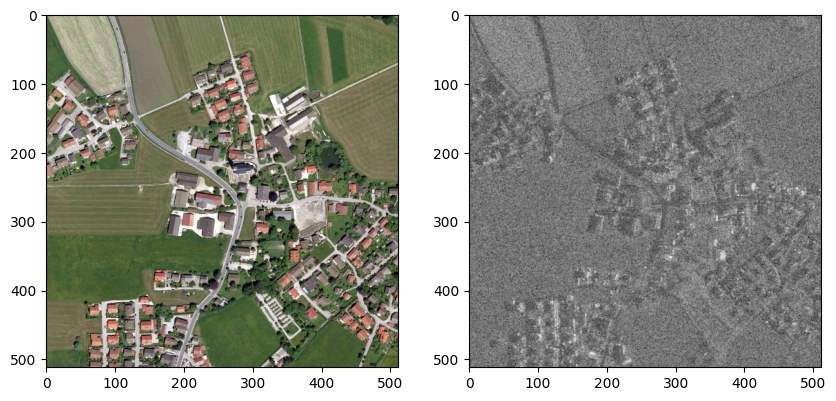

In [4]:
input_path = "../../dataset/clip_T1.mat"
data = scipy.io.loadmat(input_path)

guide = data['guide']
noisy = data['noisy']

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(guide)
plt.subplot(1, 2, 2)
plt.imshow(T(noisy), cmap='gray')

In [5]:
opt_rgb = jnp.array(guide) / 255.0
sar = T(noisy)

opt_gray = rgb2gray(opt_rgb)
opt_lab = rgb2lab(opt_rgb)

print(sar.shape, opt_gray.shape, opt_lab.shape, opt_rgb.shape)

(512, 512, 1) (512, 512, 1) (512, 512, 3) (512, 512, 3)


### Compute texture descriptor

In [6]:
params_texture_descriptor = {
    'opt': opt_lab,
    'radius': 7,
}

S = sar_despeckling._step1_compute_texture_descriptor(**params_texture_descriptor)

INFO:root:Computing texture descriptor...
INFO:root:Warning: NaN values found in texture descriptor. Replacing with zeros.
INFO:root:Texture descriptor computed in 8.23 seconds.


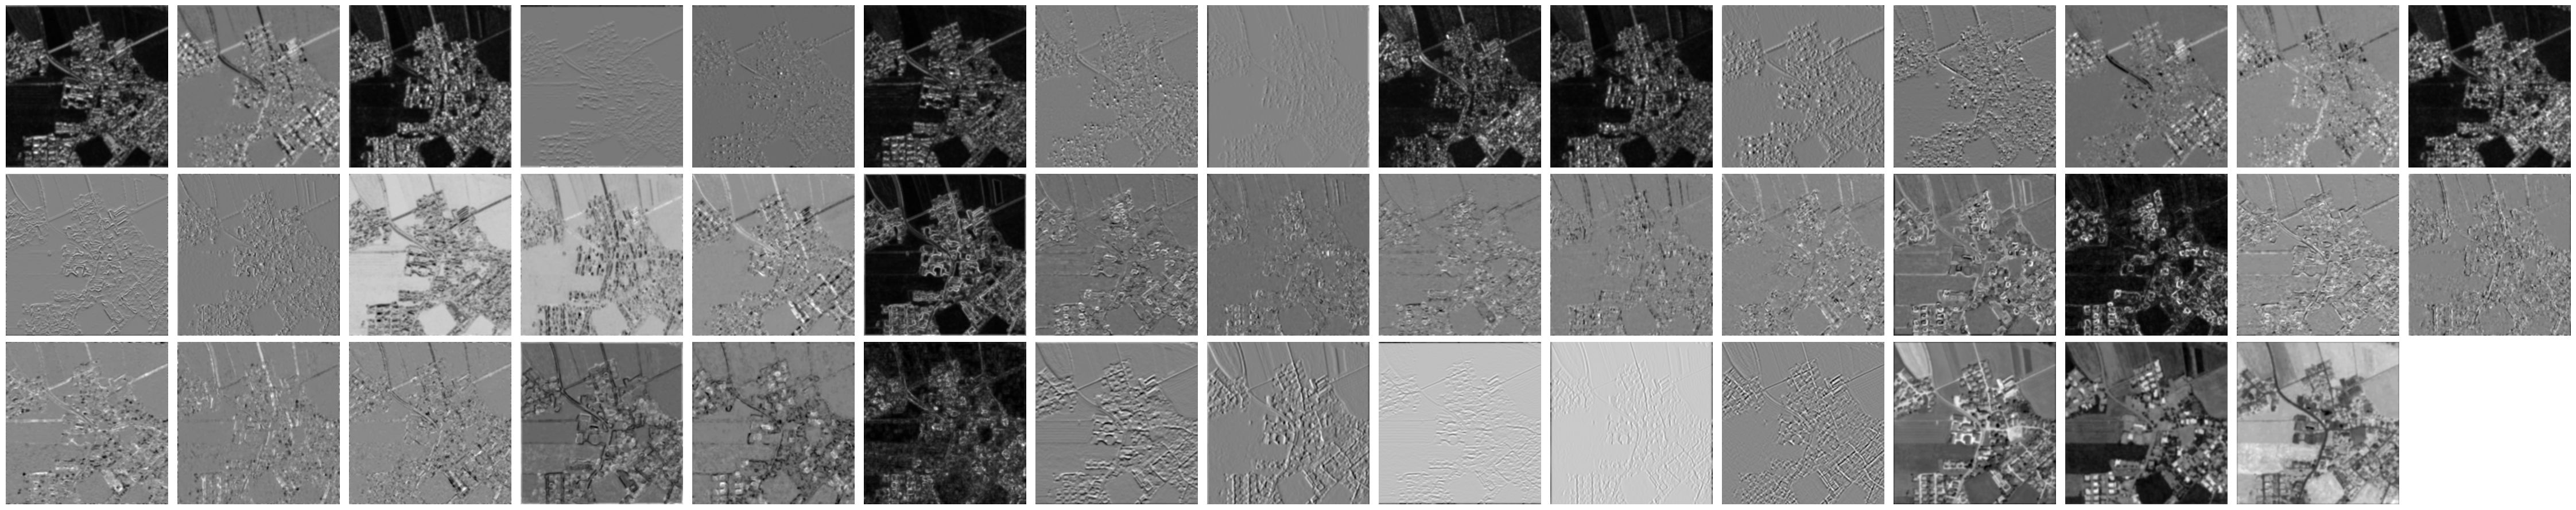

In [7]:
D = S.shape[-1]

N = 15  # Number of columns for plotting
plt.figure(figsize=(N * 3, (D // N + 1) * 3))
for i in range(D):
    plt.subplot(D // N + 1, N, i + 1)
    plt.imshow(S[:,:,i], cmap='gray')
    plt.axis('off')
plt.tight_layout()

### MUBF

In [8]:
params_mubf = {
    'target': S,
    'guides': [opt_gray, sar],  # (H, W, 1)
    'sigma_spatial': 5,
    'sigma_guides': [0.001, 0.01],
    'alpha': 5,
    'n_iterations': 150,
    'n_blocks': 10
}

S_mubf = sar_despeckling._step2_filter_texture_descriptor(**params_mubf)

INFO:root:Filtering texture descriptor with MUBF...
Iterations: 100%|██████████| 150/150 [04:10<00:00,  1.67s/it]
INFO:root:Texture descriptor filtering completed in 250.88 seconds.


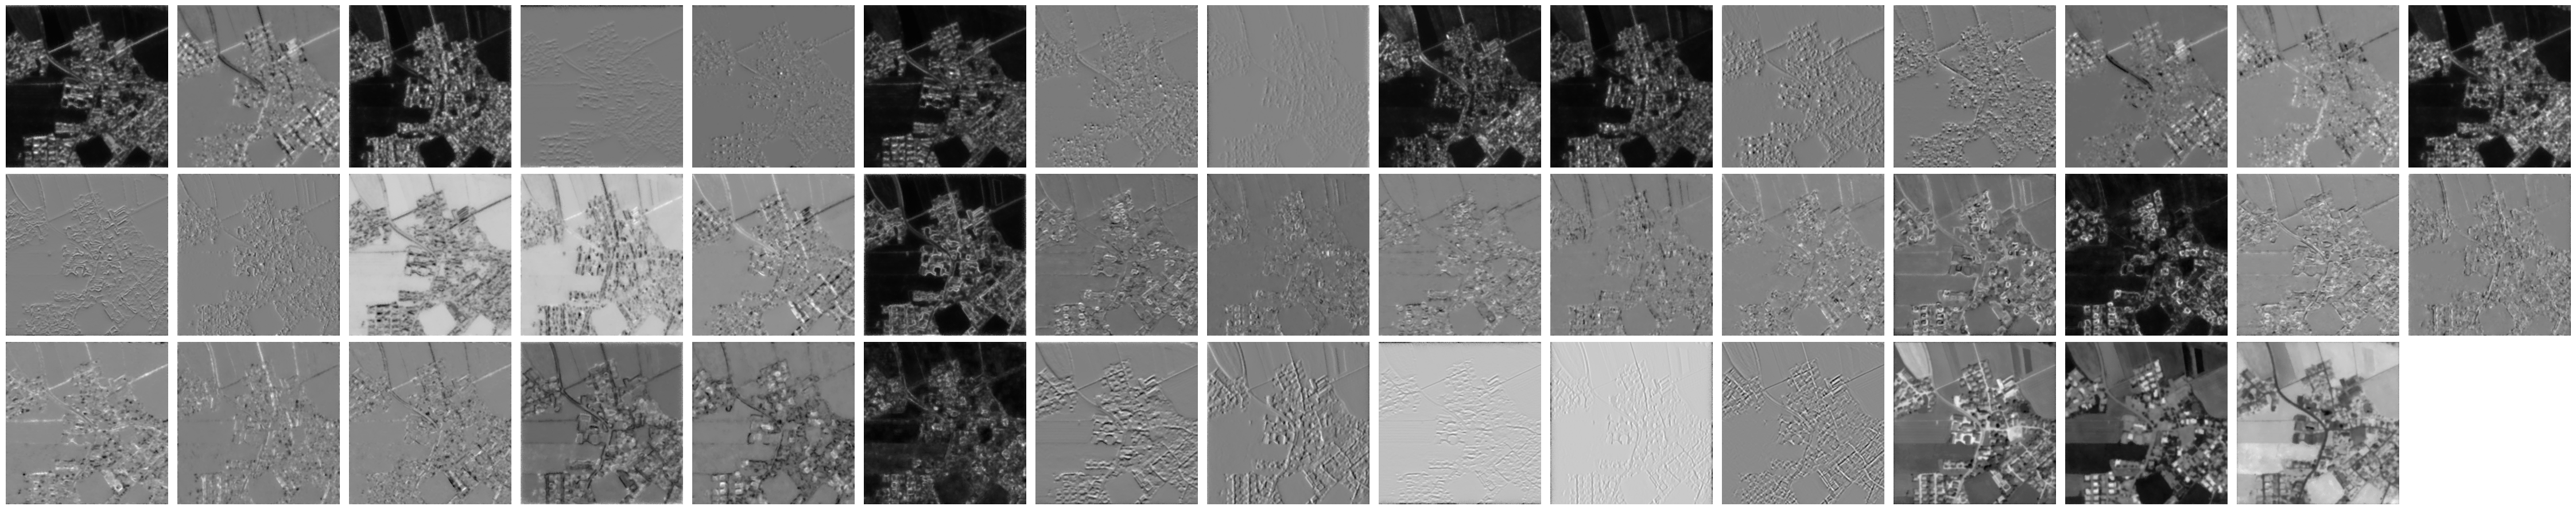

In [9]:
D = S_mubf.shape[-1]

N = 15  # Number of columns for plotting
plt.figure(figsize=(N * 3, (D // N + 1) * 3))
for i in range(D):
    plt.subplot(D // N + 1, N, i + 1)
    plt.imshow(S_mubf[:,:,i], cmap='gray')
    plt.axis('off')
plt.tight_layout()

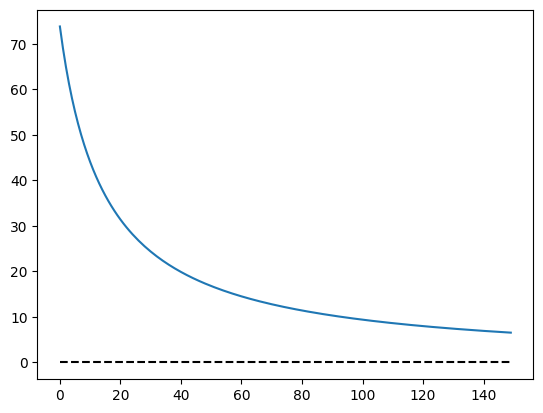

In [10]:
plt.plot(sar_despeckling.error)
plt.plot(np.arange(len(sar_despeckling.error)), np.zeros_like(sar_despeckling.error), 'k--')

### Despeckle

In [11]:
params_despeckling = {
    "sar": sar,
    "descriptor": S_mubf,
    "sigma_distance": 3,
    "radius_despeckling": 30,
    "n_blocks": 20
}

sar_filtered = sar_despeckling._step3_despeckle(**params_despeckling)

INFO:root:Despeckling SAR image...
Despeckling: 100%|██████████| 400/400 [00:08<00:00, 45.52block/s]
INFO:root:Despeckling completed in 8.94 seconds.


In [12]:
params = params_texture_descriptor | params_mubf | params_despeckling
filtered_keys = ['opt', 'target', 'guides', 'n_blocks', 'sar', 'descriptor']
for key in filtered_keys:
    params.pop(key)

params_filtered = params
name = 'tbog'
for key, value in params_filtered.items():
    if isinstance(value, list):
        value = '+'.join([str(v) for v in value])
    name += f"_{key}={value}"

name

'tbog_radius=7_sigma_spatial=5_sigma_guides=0.001+0.01_alpha=5_n_iterations=150_sigma_distance=3_radius_despeckling=30'

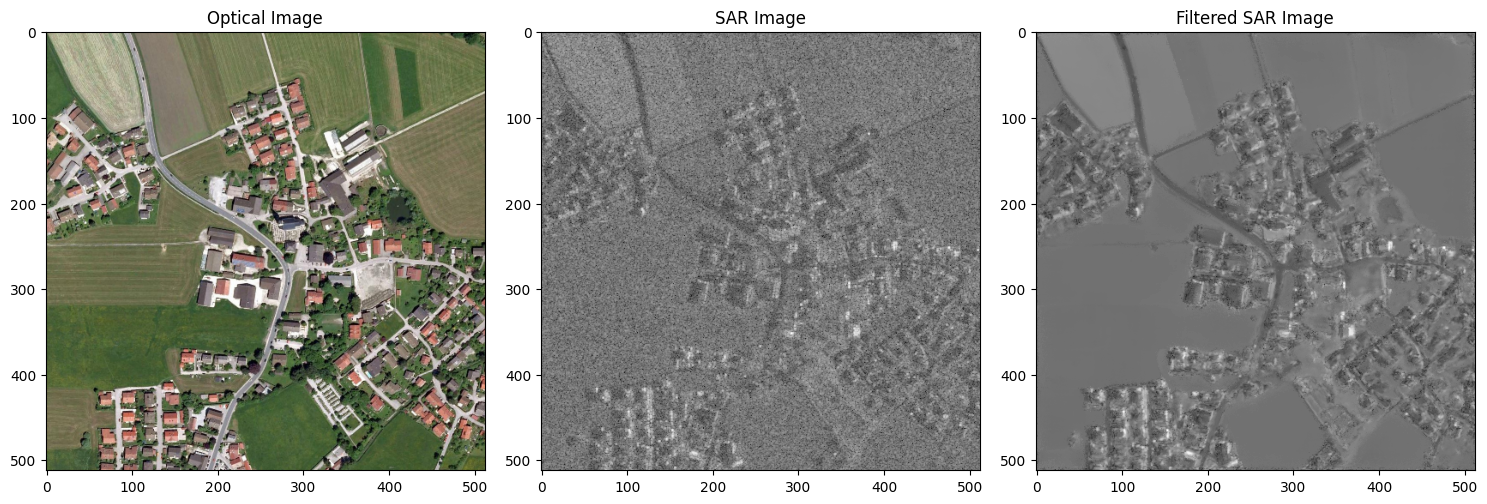

In [13]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(opt_rgb)
plt.title('Optical Image')
plt.subplot(1, 3, 2)
plt.imshow(sar, cmap='gray')
plt.title('SAR Image')
plt.subplot(1, 3, 3)
plt.imshow(sar_filtered, cmap='gray')
plt.title('Filtered SAR Image')
plt.tight_layout()
plt.savefig(f'/home/nus/Downloads/{name}.png', dpi=300)